# Exploration KREDITKARTENZAHLUNGSVERKEHR FÜR ONLINE-EINKÄUFE

In [1]:
# Importieren benötigter Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from itertools import product
from scipy.stats import chi2_contingency
import matplotlib.gridspec as gridspec
from itertools import combinations

### Daten Einlesen und Erstellen eines DF für die Transaktionskosten der PSP

In [2]:
df = pd.read_excel("../../data/raw/PSP_Jan_Feb_2019.xlsx", index_col=0)

## Exploration - Datenqualität

In [3]:
df.head()

,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50410 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50410 non-null  datetime64[ns]
 1   country     50410 non-null  object        
 2   amount      50410 non-null  int64         
 3   success     50410 non-null  int64         
 4   PSP         50410 non-null  object        
 5   3D_secured  50410 non-null  int64         
 6   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 3.1+ MB


#### Erkenntnisse:
 - 50410 Einträge ohne Fehlstellen
 - success und 3D_secured sind Integer und keine Bools
 - Restliche Datentypen sind korrekt
 - Kategorische (nicht ordinale) Variablen: country, success, PSP, card, 3D_secured
 - Kontinuierliche Variablen: tmsp, amount
##### Folge:
 - success und 3d_secured müssen nicht transformiert werden

In [5]:
df.describe()

,tmsp,amount,success,3D_secured
count,50410,50410.000000,50410.000000,50410.000000
mean,2019-01-29 16:28:52.923269120,202.395715,0.202896,0.238266
min,2019-01-01 00:01:11,6.000000,0.000000,0.000000
25%,2019-01-14 12:00:36.249999872,133.000000,0.000000,0.000000
50%,2019-01-30 15:20:07.500000,201.000000,0.000000,0.000000
75%,2019-02-13 01:09:50.500000,269.000000,0.000000,0.000000
max,2019-02-28 23:48:19,630.000000,1.000000,1.000000
std,NaN,96.274730,0.402160,0.426027


#### Erkentnisse:
 - nur 20% der Bezahlungen wurden erfolgreich abgewickelt.
 - Erfolgreiche Bezahlungen sind unterrepräsentiert.
 - 23% waren 3D Secured
 - Die durchschnittliche Bezahlsumme liegt bei 202 Euro
 - Daten vom 30.01.2019 bis 28.02.2019
##### Folge:
 - Genauigkeit ist keine gute Metrik für die Modellbewertung
 - Modell könnte höhere a-priori Wahrscheinlichkeit von Fehlbezahlungen nutzen um Vorhersagen zu machen.
 - Under/Oversampling Methoden bei der Modellentwicklung
 - Nur der Wochentag und/oder die Tageszeit können als Feature sinnvoll aus dem Zeitstempel extrahiert werden.
 - KW, Jahr und Monat würden zu einem Bias bei der Vorhersage führen.

In [6]:
# Welche und wie viele verschiedene Werte existieren in den kategorischen Featuers? 
categorial_cols = ["success","3D_secured","country","PSP","card"]
for col in categorial_cols:
    # Zählt alle einzigartigen Werte und gib diese aus:
    print(df[col].value_counts(), "\n")
    
# Zählt alle einzigartigen Werte und gib diese aus:
print("Anzahl verschiedener Werte im Feature amount:", len(df["amount"].unique()))

success
0    40182
1    10228
Name: count, dtype: int64 

3D_secured
0    38399
1    12011
Name: count, dtype: int64 

country
Germany        30233
Switzerland    10338
Austria         9839
Name: count, dtype: int64 

PSP
UK_Card       26459
Simplecard    12446
Moneycard      8297
Goldcard       3208
Name: count, dtype: int64 

card
Master    29002
Visa      11640
Diners     9768
Name: count, dtype: int64 

Anzahl verschiedener Werte im Feature amount: 517


#### Erkenntnisse:
 - Verteilungen in allen Klassen ungleichmäßig
 - Keine falschen Einträge in den Features
 - Nur wenige verschiedene Werte in den Features

##### Folgen:
 - Behandlung ungleichmäßiger Verteilungen
 - One Hot enconding geeignet für Transformierung der kategorischen Variablen

In [7]:
# Liste alle exakten Duplikate
df[df.duplicated()]

,tmsp,country,amount,success,PSP,3D_secured,card
84,2019-01-01 01:28:02,Germany,37,0,UK_Card,0,Master
496,2019-01-01 09:35:38,Germany,170,0,UK_Card,0,Diners
500,2019-01-01 09:44:27,Germany,113,0,UK_Card,0,Visa
603,2019-01-01 11:32:44,Germany,170,0,UK_Card,0,Visa
1393,2019-01-02 03:06:14,Austria,229,0,UK_Card,0,Master
...,...,...,...,...,...,...,...
49517,2019-02-27 21:50:28,Germany,186,0,UK_Card,0,Visa
49809,2019-02-28 06:10:53,Germany,29,0,UK_Card,0,Master
50329,2019-02-28 21:36:07,Switzerland,161,0,UK_Card,0,Visa
50399,2019-02-28 23:33:01,Germany,208,0,UK_Card,0,Master


#### Erkenntnisse:
 - 81 exakte Duplikate vorhanden
 - Diese bringen keine neuen Infomationen

##### Folgen:
 - Exakte Duplikate entfernen, da diese zu einer Verzerrung führen

## Outlier Detection
 - die kategorischen Variablen enthalten keine singulären "Outlier"
 - daher wird nur das Feature "amount" betrachtet

In [8]:
# Outlier Detektion:
from pyod.models.knn import KNN

continuous_column = 'amount'

# PyOD Isolation Forest Modell initialisieren
model = KNN()

# Trainieren des Modells auf den kontinuierlichen Spalten
model.fit(df[[continuous_column]])

# Vorhersage der Ausreißer
outlier_scores = model.decision_function(df[[continuous_column]])
outlier_labels = model.predict(df[[continuous_column]])

# Ausreißer markieren
df['Is_Outlier'] = outlier_labels

In [9]:
df[df["Is_Outlier"]==1]

,tmsp,country,amount,success,PSP,3D_secured,card,Is_Outlier
372,2019-01-01 07:26:03,Germany,450,0,Simplecard,0,Visa,1
506,2019-01-01 09:48:03,Germany,488,0,UK_Card,0,Master,1
507,2019-01-01 09:48:48,Germany,488,0,UK_Card,0,Master,1
508,2019-01-01 09:49:35,Germany,488,0,Simplecard,0,Master,1
509,2019-01-01 09:49:41,Germany,488,0,UK_Card,0,Master,1
...,...,...,...,...,...,...,...,...
48556,2019-02-26 17:55:06,Germany,538,0,UK_Card,0,Master,1
48557,2019-02-26 17:55:11,Germany,538,0,Simplecard,0,Master,1
48558,2019-02-26 17:55:46,Germany,538,1,Moneycard,0,Master,1
50258,2019-02-28 19:24:55,Germany,463,0,UK_Card,1,Visa,1


### Erkenntnis:
 - Es wurde 110 Ausreißer gefunden bei hohen Zahlungen gefunden.
### Folge:
 - Eine Entfernung der Datenpunkte könnte sich positiv auf die Performance eines Modells auswirken.
 - Eine Entfernung kann dem Modell aber auch wesentliche Informationen vorenthalten.
 - Auf eine Entfernung wird zunächst verzichtet. 

## Exploration - Datenverständnis

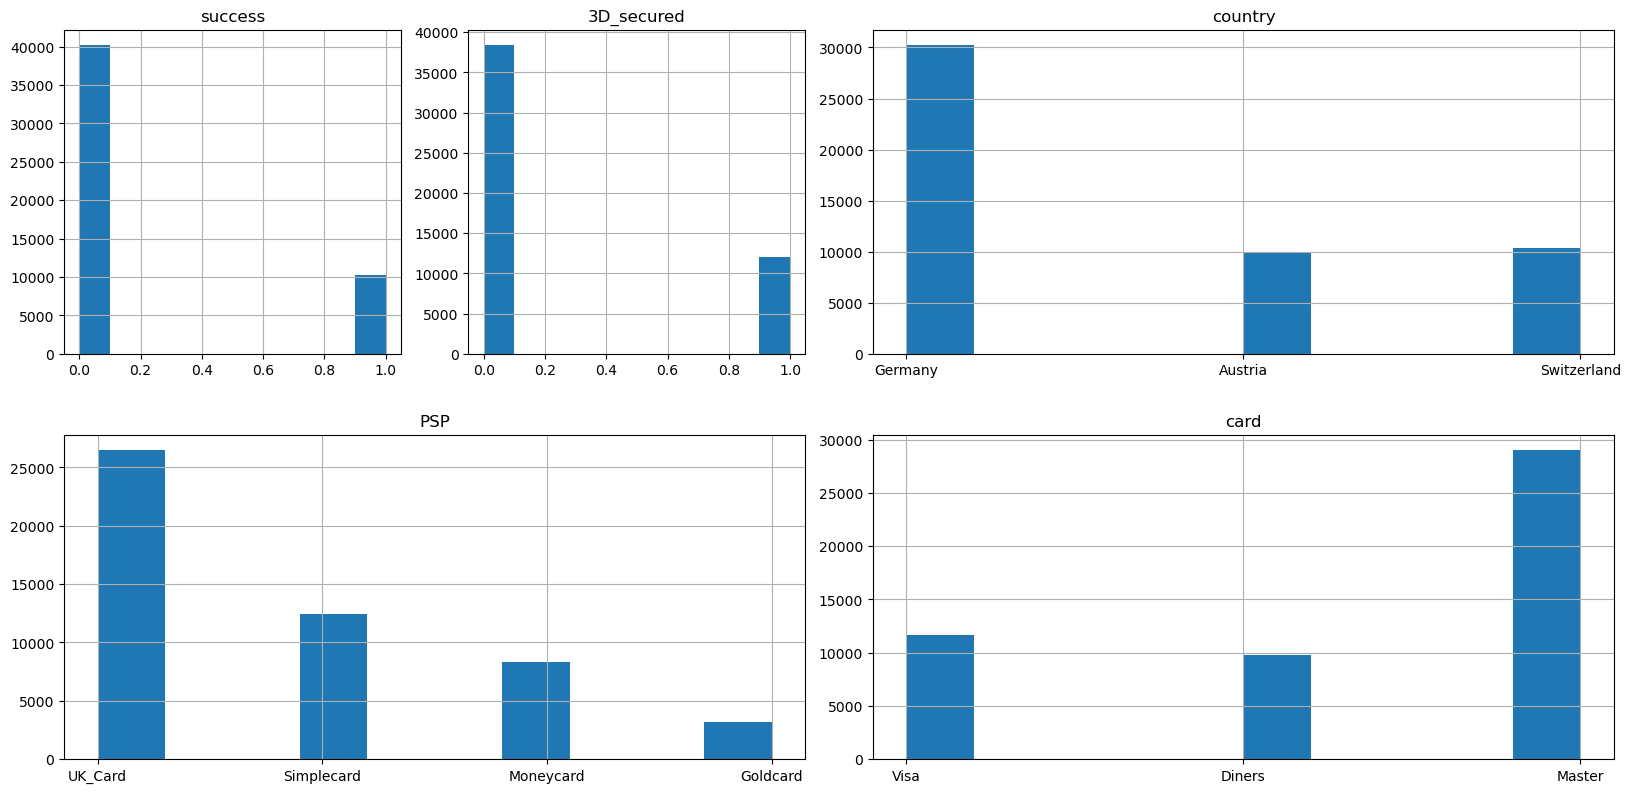

In [10]:
# Erstellen eines Plots von Histogrammen von allen kategorischen Variablen.
plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(4, 12)
gs.update(wspace=1.0, hspace=0.25)
# Subplots erstellen
ax1 = plt.subplot(gs[0, :3])
ax2 = plt.subplot(gs[0, 3:6])
ax3 = plt.subplot(gs[0, 6:])
ax4 = plt.subplot(gs[1, 0:6])
ax5 = plt.subplot(gs[1, 6:])
for ax, col in zip([ax1,ax2,ax3,ax4,ax5],categorial_cols):
    # Subplots iterativ mit Plots füllen
    df[col].hist(ax=ax)
    ax.set_title(col)
# Speichern des Plots
plt.savefig("../../documentation/data-reports/categorical.pdf", format="pdf", bbox_inches="tight")
# Anzeigen des Plots
plt.show()

#### Erkenntnisse: 
 - Keine kategoriale Spalte hat fehlerhafte Einträge
 - Alle psp provider, die in der Aufgabenstellung gegeben sind sind auch in den Daten enthalten.
 - Unausgelichene Verteilung für PSP, Country und Card

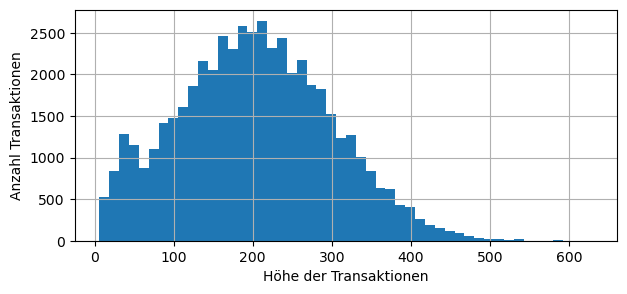

In [11]:
# Histogramm für die kontinuierliche Variable erstellen:
plt.figure(figsize=(7,3))
# 50 bins, in die die Werte eingeornet werden.
df["amount"].hist(bins=50);
# Achsenbeschriftung
plt.xlabel("Höhe der Transaktionen");
plt.ylabel("Anzahl Transaktionen");
# Speichern des PLots
plt.savefig("../../documentation/data-reports/amount.pdf", format="pdf", bbox_inches="tight")

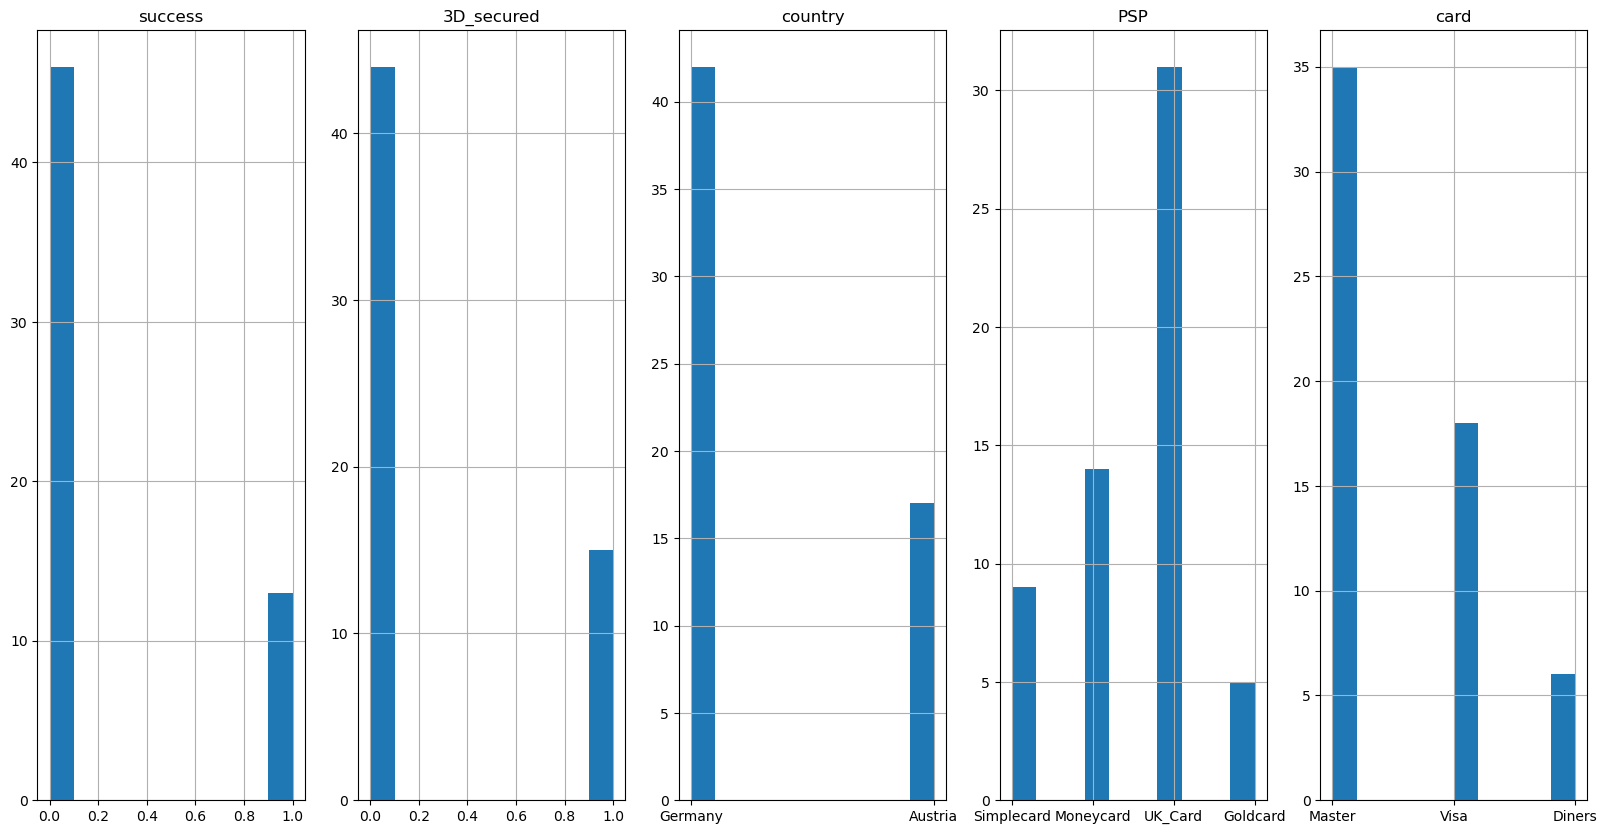

In [12]:
fig, ax = plt.subplots(1, len(categorial_cols), figsize=(20, 10))
for i, col in enumerate(categorial_cols):
    df[df["amount"]>500][col].hist(ax=ax[i])
    ax[i].set_title(col)

#### Erkenntnisse 
 - Kontinuierliche Variable
 - Rechtsschiefe Verteilung 
 - Transaktionen über 500 € gab es nicht in der Schweiz
 - Restliche Verteilungen zeigen nur kleine Unterschiede zum gesamten Datensatz
##### Folge:
 - Logarithmieren des Feature amount

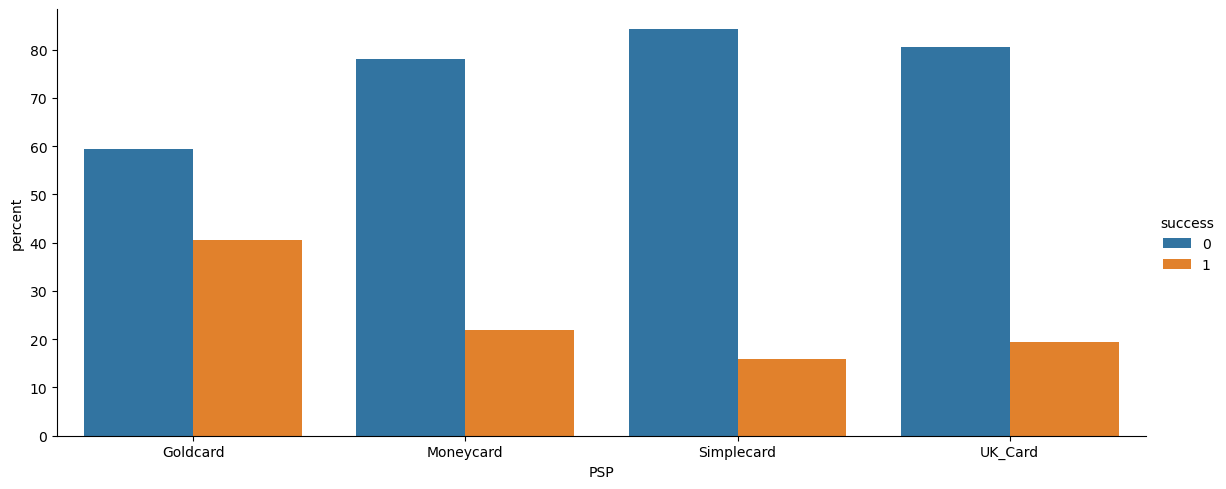

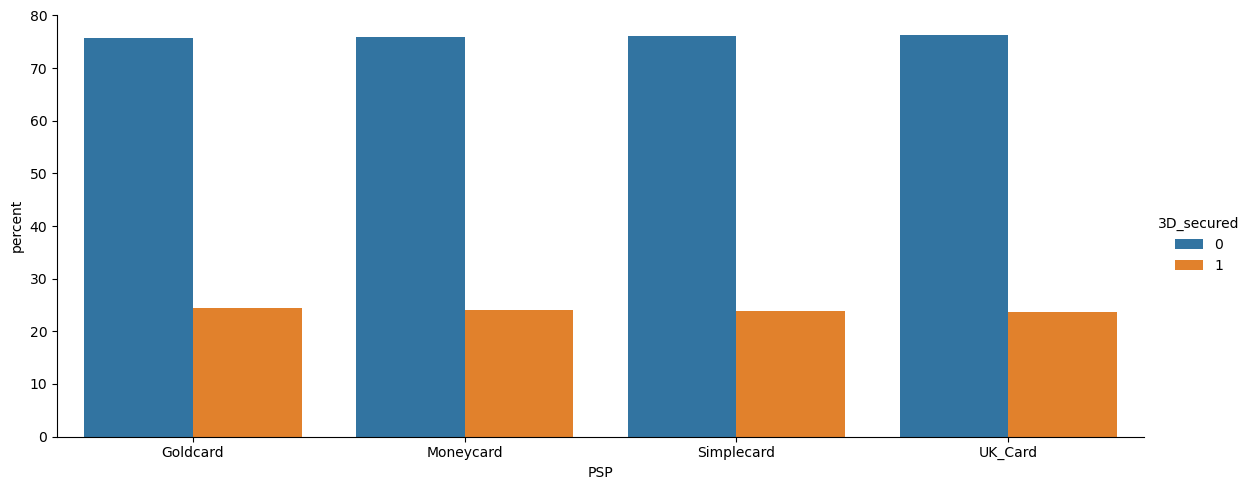

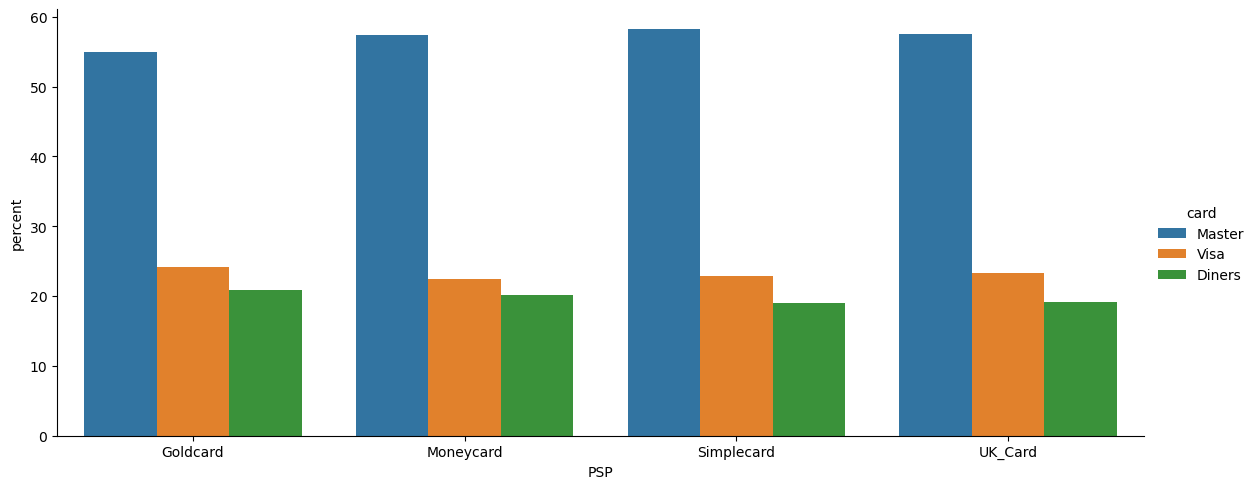

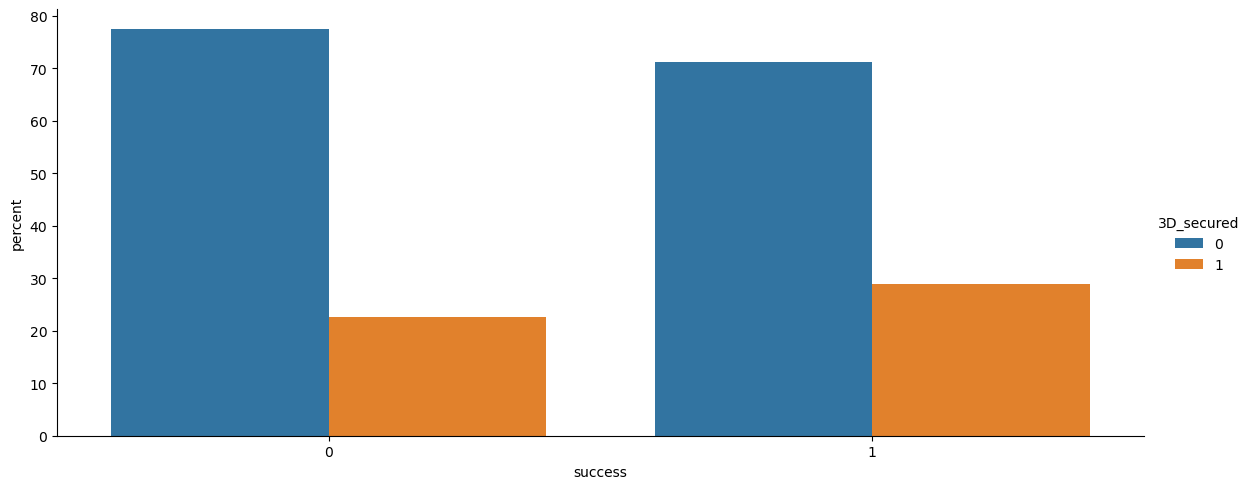

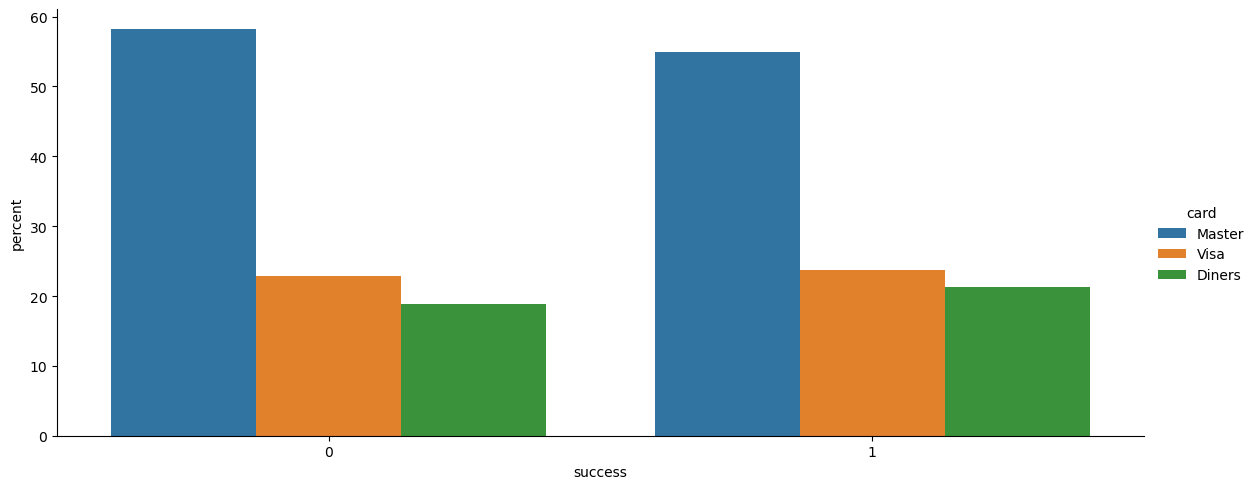

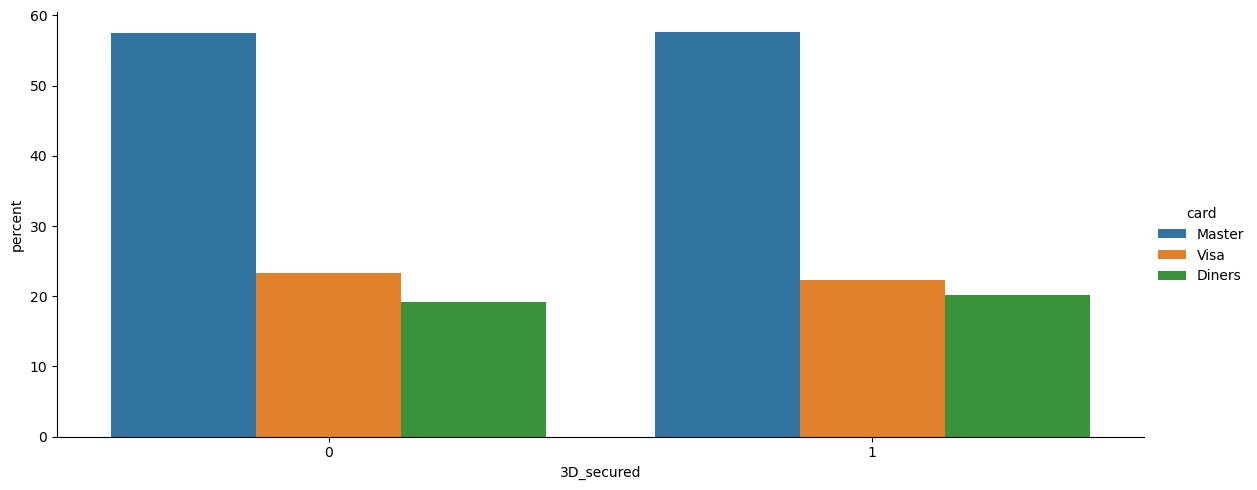

In [45]:
categorial_cols = ["PSP","success","3D_secured","card"]
for i in combinations(categorial_cols, 2):
    # Erstellen von Barplots für jede Kombination der kategorischen Variablen 
    data = df.groupby(i[0])[i[1]].value_counts(normalize=True).mul(100).rename('percent').reset_index().copy()
    data[i[1]]=data[i[1]].astype(str)
    data.pipe((sns.catplot,'data'), x=i[0],y='percent',hue=i[1],kind='bar',aspect=7/3);

### Erkenntnisse:
 - Goldcard hat die höchste Erfolgsquote
 - 3D gesichert erhöht die Erfolgsquote
### Folgen:
- Goldcard könnte in Modellvorhersage immer die höchste Erfolgswahrscheinlichkeit besitzen.

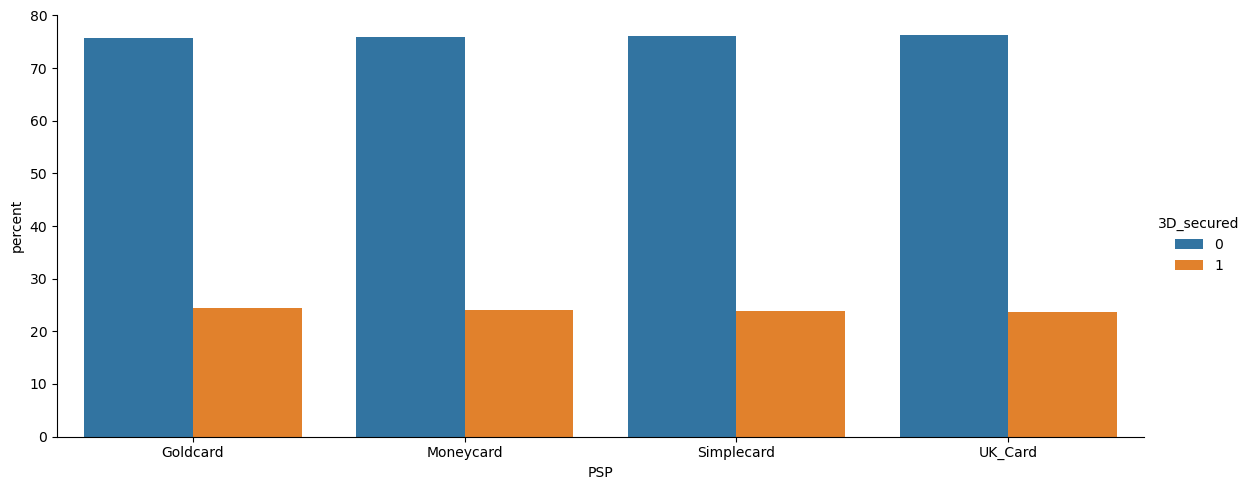

In [47]:
# Speichern eines relevanten Plots
data = df.groupby("PSP")["3D_secured"].value_counts(normalize=True).mul(100).rename('percent').reset_index().copy()
data["3D_secured"]=data["3D_secured"].astype(str)
data.pipe((sns.catplot,'data'), x='PSP',y='percent',hue="3D_secured",kind='bar',  aspect=7/3);
plt.savefig("../../documentation/data-reports/psp_vs_3D_secured.pdf", format="pdf", bbox_inches="tight")

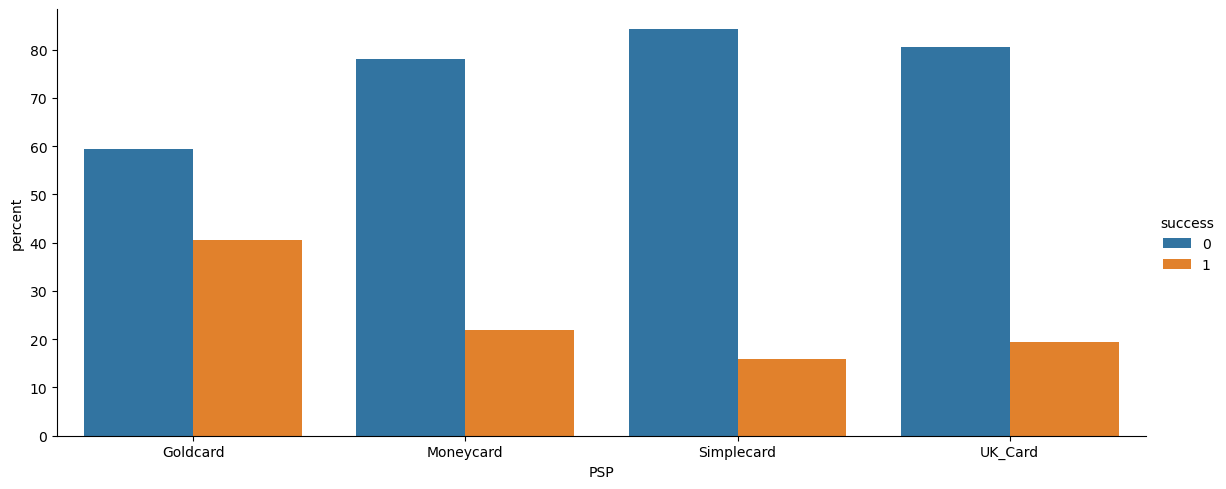

In [48]:
# Speichern eines relevanten Plots
data = df.groupby("PSP")["success"].value_counts(normalize=True).mul(100).rename('percent').reset_index().copy()
data["success"]=data["success"].astype(str)
data.pipe((sns.catplot,'data'), x='PSP',y='percent',hue="success",kind='bar',aspect=7/3);
plt.savefig("../../documentation/data-reports/psp_vs_success.pdf", format="pdf", bbox_inches="tight")

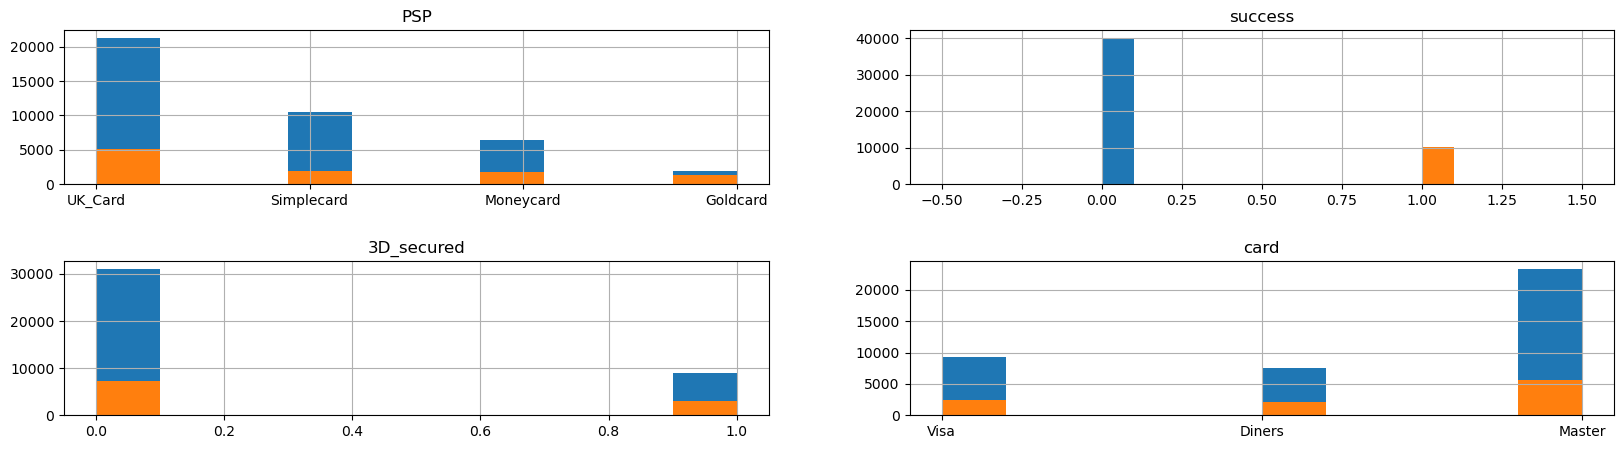

In [49]:
# Plot der Erfolge / Misserfolge im Histogramm in Abh. von anderen kategorischen Variablen.
fig, (ax1, ax2) = plt.subplots(2, int(len(categorial_cols)/2), figsize=(20, 5))
for i, col in enumerate(categorial_cols):
    if i <2:
        # Top row
        df[df["success"]==0][col].hist(ax=ax1[i])
        df[df["success"]==1][col].hist(ax=ax1[i])
        ax1[i].set_title(col)
    else:
        # Bottom row
        df[df["success"]==0][col].hist(ax=ax2[i-2])
        df[df["success"]==1][col].hist(ax=ax2[i-2])
        ax2[i-2].set_title(col)
plt.subplots_adjust(hspace=0.5)

#### Erkenntnisse 
 - Auch innerhalb der Gruppierungen von erfolgreichen/fehlgeschlagenen Transaktionen gibt es bei jedem kategorischen Feature eine unterrepräsentierte Klassen. z.B. "Goldcard"
##### Folge:
 - Ggf. Behandlung

In [50]:
# Berechnen der Durchschnittlichen Höhe der Transaktion je Kategorie in den kategorischen Features.
categorial_cols.append("success")
for col in categorial_cols:
    # Liste von verschiedenen Einträgen im Feature
    category_vals = set(df[col].values)
    for val in category_vals:
        # Berechnen und Ausgeben der durchschnittlichen Transaktionshöhe je Feature und Eintrag
        print(col+", "+ str(val)+": "+ str(df[df[col]==val]["amount"].mean()))

PSP, Goldcard: 203.39557356608478
PSP, Simplecard: 201.35666077454604
PSP, UK_Card: 202.92093427567178
PSP, Moneycard: 201.89285283837532
success, 0: 206.59344980339455
success, 1: 185.90438013296833
3D_secured, 0: 202.38612984713143
3D_secured, 1: 202.42635917076015
card, Diners: 202.4552620802621
card, Master: 202.18505620302048
card, Visa: 202.87061855670103
success, 0: 206.59344980339455
success, 1: 185.90438013296833


#### Erkenntnisse:
 - Wesentliche Abhängigkeit zwischen Höhe der Transaktion und Erfolg.
 - Restliche Features sehr ähnlich
#### Folgen:
 - Amount ist ein wichtiges Feature für ein ML-Modell

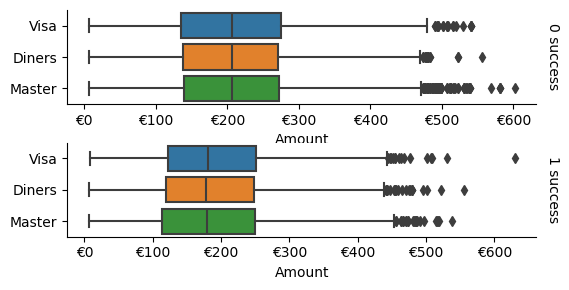

In [51]:
# Erstellen von Boxplots zur Visualisierung der Abhängigkeiten zwischen kontinuierlichen und kategorischen Variablen.
# In diesem Fall card und success.
g = sns.catplot(
    data=df,
    x="amount", y="card", row="success",
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
)
g.set(xlabel="Amount", ylabel="")
g.set_titles(row_template="{row_name} success")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter('€{x:.0f}')

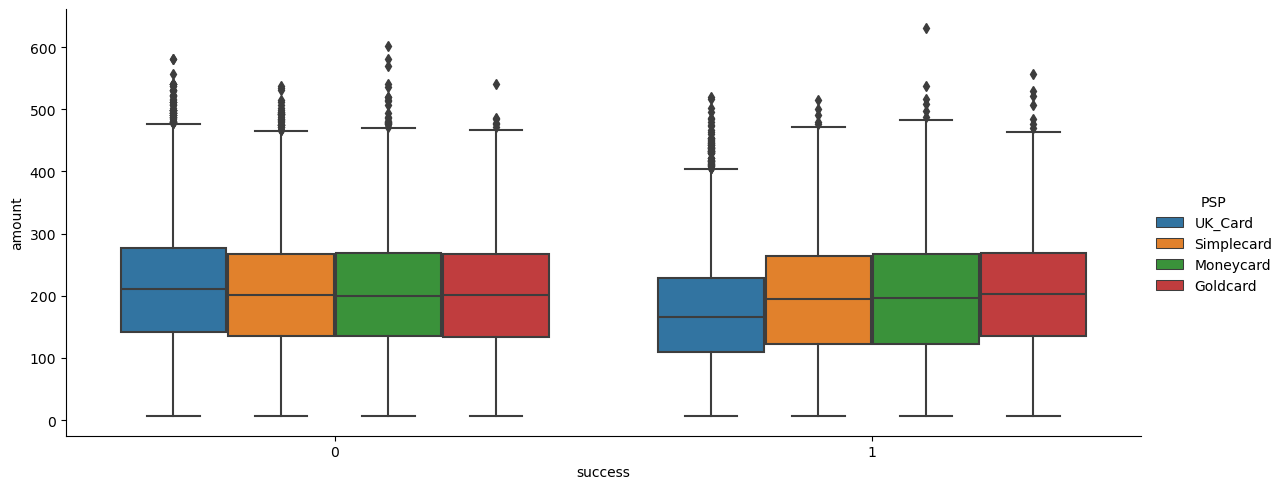

In [52]:
# Erstellen von Boxplots zur Visualisierung der Abhängigkeiten zwischen kontinuierlichen und kategorischen Variablen.
# In diesem Fall jedes kategorisch Feature einzeln.
sns.catplot(data=df, x="success", y="amount", kind="box", hue="PSP",  aspect=7/3);
plt.savefig("../../documentation/data-reports/success_vs_amount.pdf", format="pdf", bbox_inches="tight")

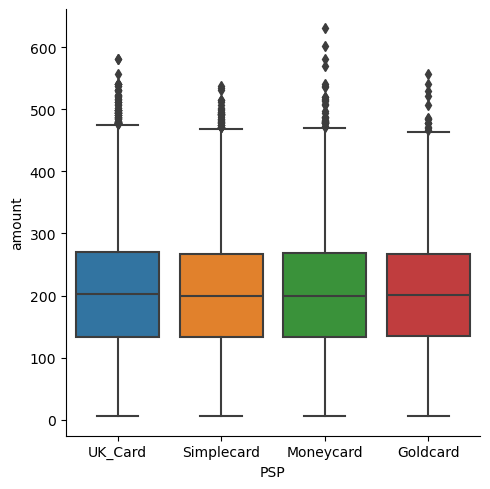

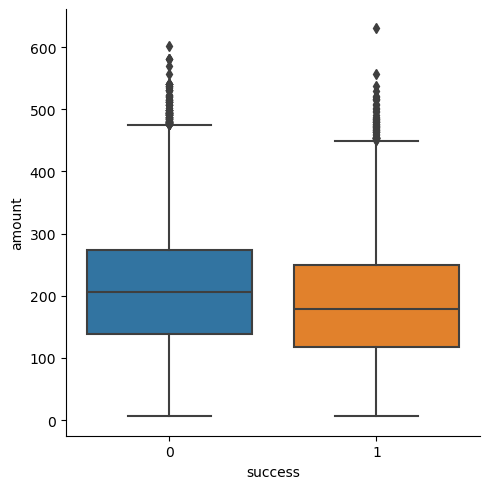

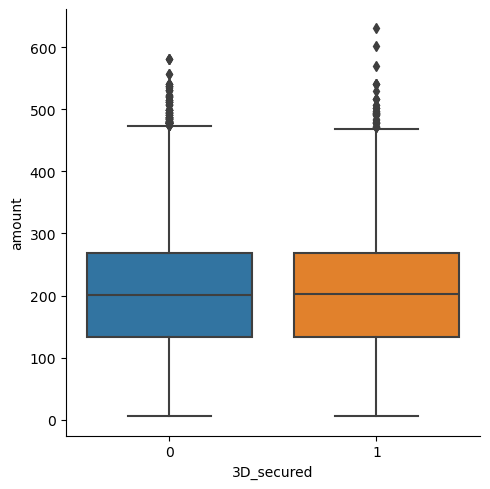

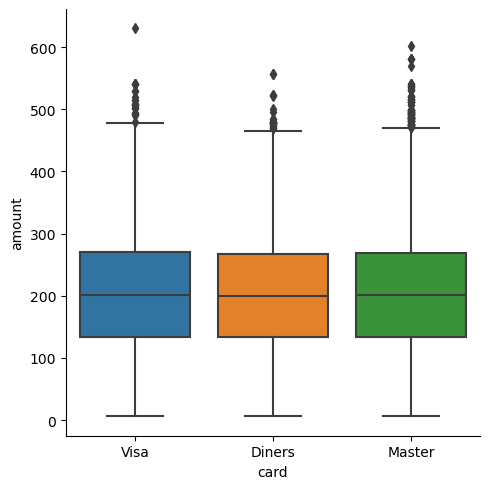

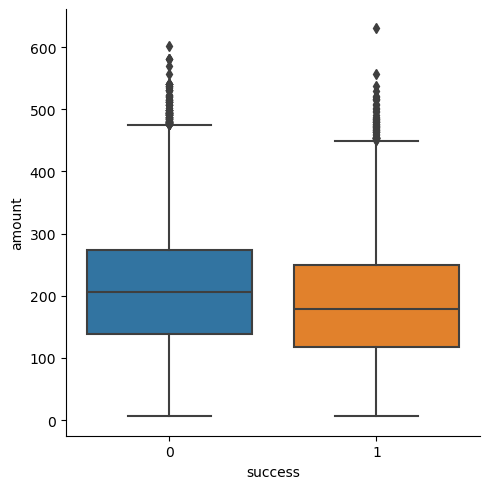

In [53]:
# Erstellen von Boxplots zur Visualisierung der Abhängigkeiten zwischen kontinuierlichen und kategorischen Variablen.
# In diesem Fall card und success.
for col in categorial_cols:
    sns.catplot(data=df, x=col, y="amount", kind="box")

#### Erkenntnisse:
 - der Erfolg der Transaktionen ist der einzige Parameter, der in dieser Statistik einen größeren Einfluss auf die Höhe der Transaktion hat.
 - UK Card ist bei kleineren Beträgen eher erfolgreich
#### Folge:
 - Höhe der Zahlungen kann wichtigstes Feature für die Modellentwicklung sein.

### Zerlegen des Zeitstempels in auswertbare Features

In [54]:
# Erstellen von neuen Spalten für Zeitstempelfeature
df['second'] = df.tmsp.dt.second
df['minute'] = df.tmsp.dt.minute
df["hour"] = df.tmsp.dt.hour
df["week_day"] = df.tmsp.dt.weekday

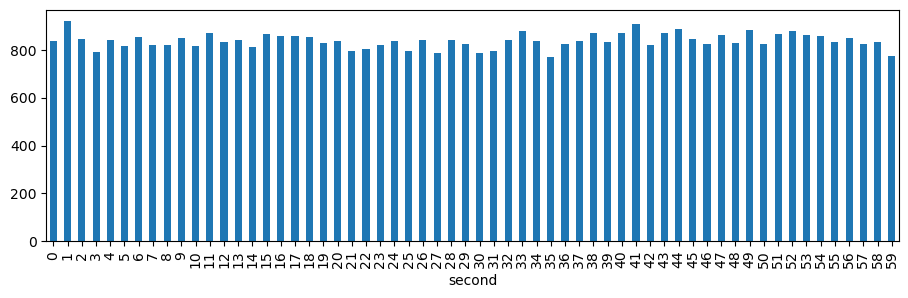

In [55]:
# Histogramm der Sekunden, in denen die Transaktion erfolgt ist.
plt.figure(figsize=(11,3))
df['second'].value_counts().sort_index().plot(kind='bar');

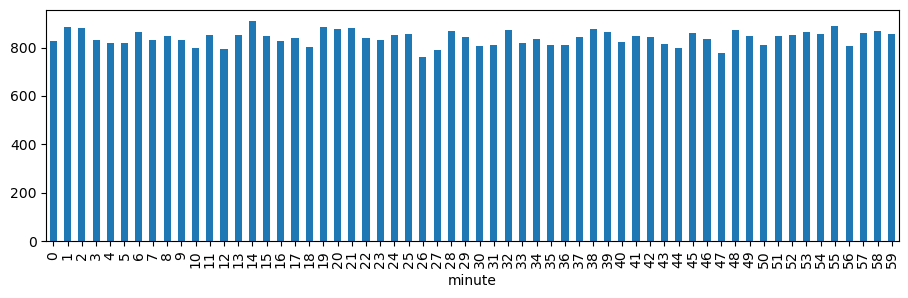

In [56]:
# Histogramm der Minuten, in denen die Transaktion erfolgt ist.
plt.figure(figsize=(11,3))
df['minute'].value_counts().sort_index().plot(kind='bar');

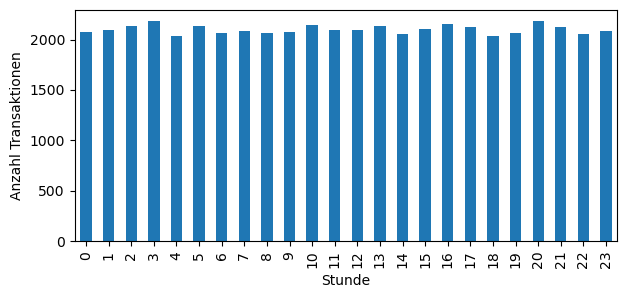

In [57]:
# Histogramm der Stunden, in denen die Transaktion erfolgt ist.
plt.figure(figsize=(7,3))
df['hour'].value_counts().sort_index().plot(kind='bar');
plt.xlabel("Stunde");
plt.ylabel("Anzahl Transaktionen");
plt.savefig("../../documentation/data-reports/hourly_transactions.pdf", format="pdf", bbox_inches="tight")

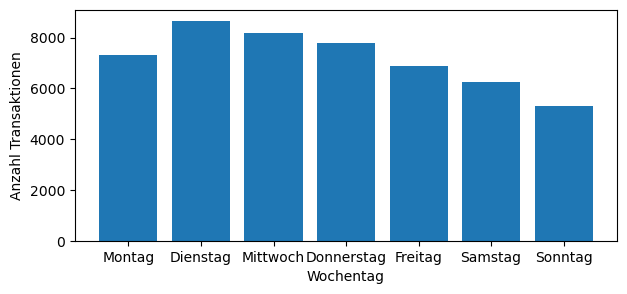

In [58]:
# Histogramm der Wochentage, an denen die Transaktion erfolgt ist.
plt.figure(figsize=(7,3))
plt.bar(df['week_day'].value_counts().sort_index().index,df['week_day'].value_counts().sort_index());
plt.xlabel("Wochentag")
plt.ylabel("Anzahl Transaktionen")
plt.xticks([0,1,2,3,4,5,6],["Montag","Dienstag","Mittwoch","Donnerstag","Freitag","Samstag","Sonntag"]);
plt.savefig("../../documentation/data-reports/weekly_transactions.pdf", format="pdf", bbox_inches="tight")

C:\Users\marvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


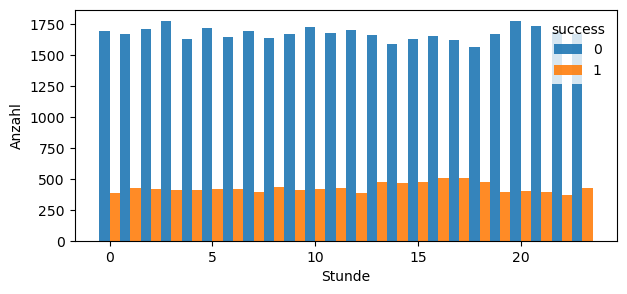

In [69]:
plt.figure(figsize=(7,3))
sns.set_context(rc = {'patch.linewidth': 0.0})
sns.histplot(data=df, x="hour", hue="success", multiple="dodge", discrete=True, alpha=0.9);
plt.xlabel("Stunde");
plt.ylabel("Anzahl");
plt.savefig("../../documentation/data-reports/hourly_transactions_success.pdf", format="pdf", bbox_inches="tight")

C:\Users\marvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


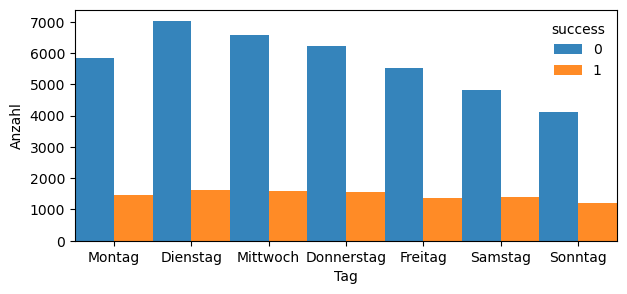

In [70]:
plt.figure(figsize=(7,3))
sns.histplot(data=df, x="week_day", hue="success", multiple="dodge", discrete=True, alpha=0.9);
plt.margins(x=0.001)
plt.xlabel("Tag");
plt.ylabel("Anzahl");
plt.xticks([0,1,2,3,4,5,6],["Montag","Dienstag","Mittwoch","Donnerstag","Freitag","Samstag","Sonntag"]);
plt.savefig("../../documentation/data-reports/weekly_transactions_success.pdf", format="pdf", bbox_inches="tight")

In [71]:
# Abhängigkeit zwischen Wochentag und Höhe der Transaktion
df.groupby("week_day")["amount"].mean()

week_day
0    198.223987
1    203.175574
2    202.331910
3    202.063238
4    204.077547
5    203.960860
6    203.423952
Name: amount, dtype: float64

In [72]:
# Wahrscheinlichkeit für Erfolg je Wochentag:
df.groupby("week_day")["success"].mean()

week_day
0    0.201123
1    0.187810
2    0.195851
3    0.199461
4    0.198580
5    0.224254
6    0.226358
Name: success, dtype: float64

In [73]:
# Wahrscheinlichkeit für Erfolg je Stunde:
df.groupby("hour")["success"].mean()

hour
0     0.186718
1     0.201624
2     0.197091
3     0.187643
4     0.200295
5     0.195122
6     0.202906
7     0.189448
8     0.208132
9     0.196824
10    0.194120
11    0.201429
12    0.184990
13    0.223573
14    0.227295
15    0.226021
16    0.233875
17    0.238230
18    0.231336
19    0.192066
20    0.185321
21    0.185412
22    0.178276
23    0.202204
Name: success, dtype: float64

#### Erkenntnisse:
 - Die meisten Transaktionen finden Dienstags statt.
 - Die Tageszeit hat keinen Einfluss auf die totale Anzahl an Transaktionen.
 - Zwischen 13 und 18 Uhr ist die Anzahl/ der Anteil an erfolgreichen Transaktionen höher.
 - Das Verhältnis von erfolgreichen zu nicht erfolgreichen Transaktionen steigt zum Wochenende

C:\Users\marvi\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\marvi\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


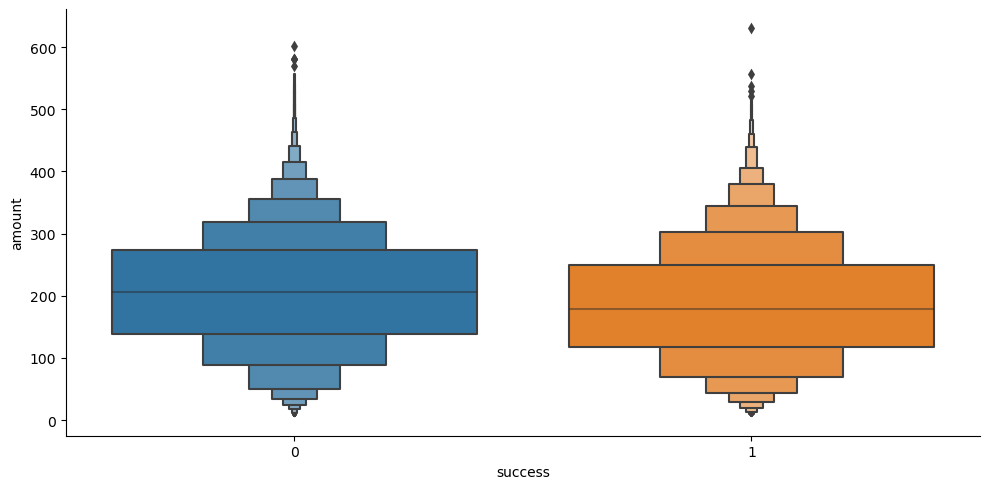

In [74]:
# Erstellen eines vorzeigbaren Boxplots für die Abhängigkeit zwischen Erfolg und Höhe der Transaktion
sns.catplot(data=df, x="success", y="amount", kind="boxen",  aspect=4/2);
plt.savefig("../../documentation/data-reports/amount_vs_success.pdf", format="pdf", bbox_inches="tight")

C:\Users\marvi\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\marvi\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\marvi\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\marvi\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

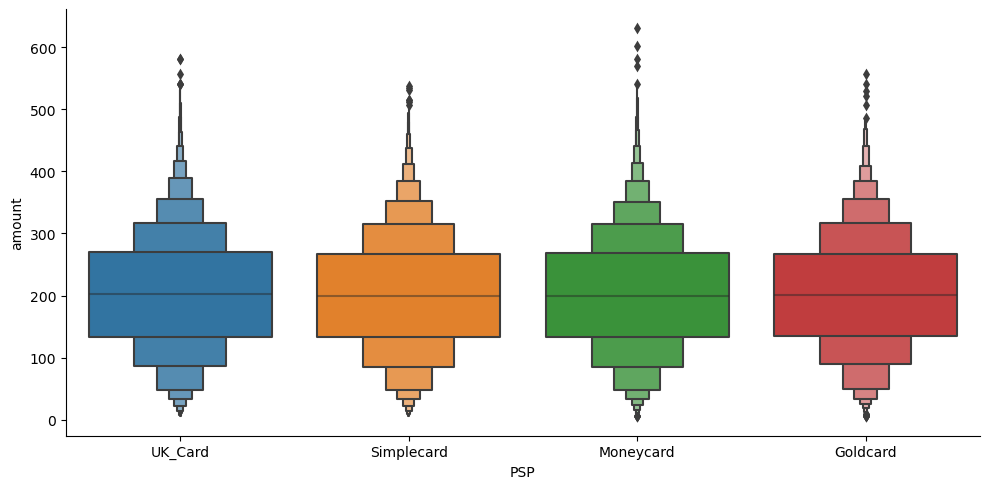

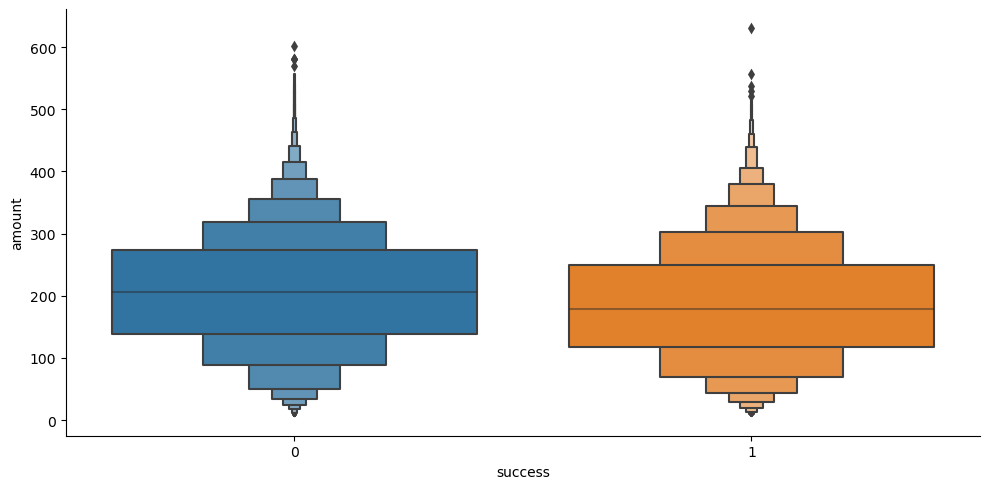

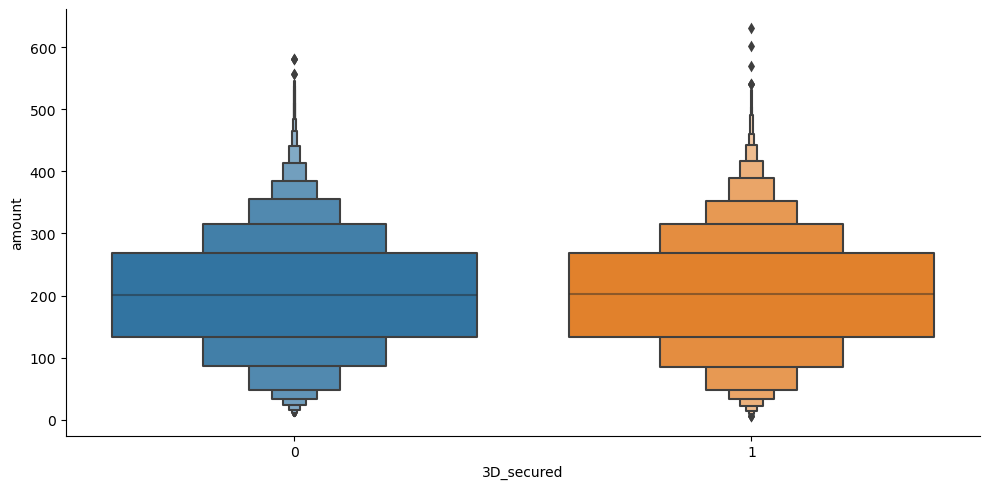

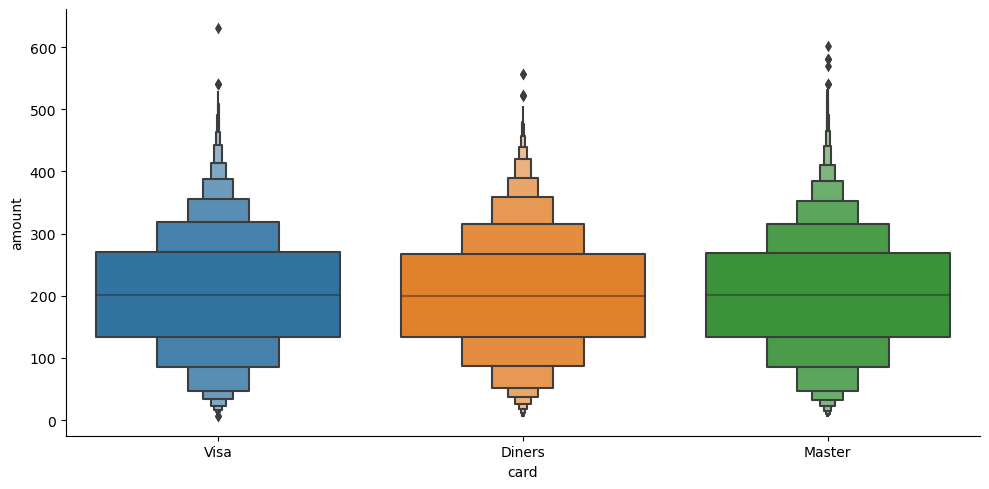

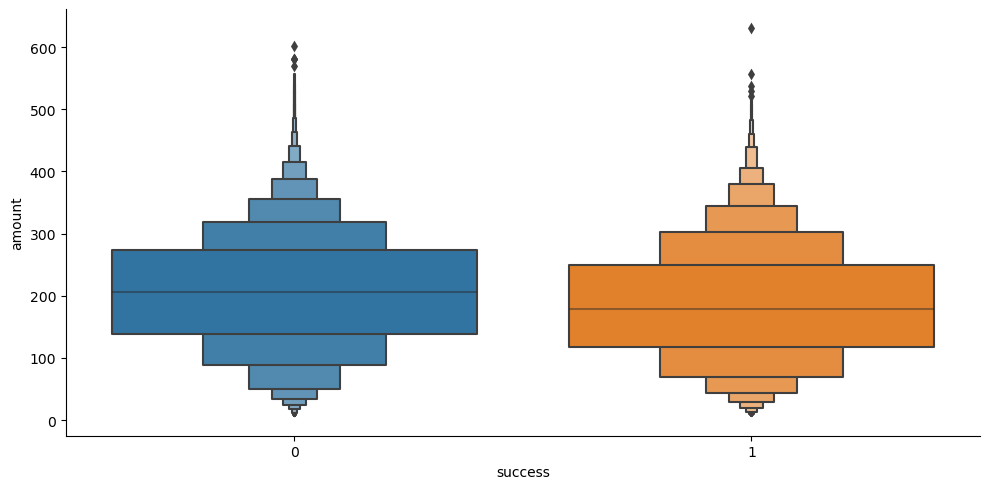

In [75]:
# Erstellen der Boxplots für alle anderen kategorischen Variablen
for col in categorial_cols:
    sns.catplot(data=df, x=col, y="amount", kind="boxen",  aspect=4/2);

## Beziehung zwischen kategorischen Variablen - Chi2-Test

### H0: Es gibt keine Beziehung zwischen zwei gegebenen kategorischen Variablen

### H1: Es gibt eine Beziehung zwischen zwei gegebenen kategorischen Variablen

 - p-Wert < 0,05: H0 wird verworfen
 - p-Wert >= 0,05: H0 ist wahr

#### Je kleiner der p-Wert ist, umso unwahrscheinlicher ist es, dass die Nullhypothese H0 stimmt, und umso wahrscheinlicher wird es, dass die Hypothese H1 wahr ist.

In [76]:
def perform_chi_square_test(data, col1, col2):
    """
    Function to perform chi^2 Test 
    Input Args:
    - data: pd.DataFrame -> 
    - col1: First column to perform chi^2 test
    - col2: Secon column to perform chi^2 test
    """
    # Häufigkeitstabelle erstellen
    contingency_table = pd.crosstab(data[col1], data[col2])
    # Chi^2 Test durchführen
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # Prüfen, ob p-Wert <0,05 und setzen eines boolschen Wertes
    significant = p < 0.05
    return chi2, p, significant

In [77]:
# Kategorische Variablen
categorial_cols = ["PSP","country","success","3D_secured","card"]
# Erstellen aller Permutationen
cat_var_prod = list(product(categorial_cols,categorial_cols, repeat = 1))

result = []

# Iterative Durchführung des chi^2 Tests mit allen Permutationen.
for i in cat_var_prod:
    if i[0] != i[1]:
        chi2, p_value, significant = perform_chi_square_test(df,i[0],i[1])
        result.append((i[0],i[1],p_value))

# Erstellen eines DataFrame aus den Ergebnissen
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2','coeff'])
# Pivot DataFrame
chi_test_output.pivot(index='var1', columns='var2', values='coeff')

var2,3D_secured,PSP,card,country,success
var1,,,,,
3D_secured,NaN,8.314963e-01,1.146344e-02,0.121576,2.392241e-40
PSP,8.314963e-01,NaN,1.354058e-02,0.297471,3.312365e-216
card,1.146344e-02,1.354058e-02,NaN,0.036350,1.144670e-09
country,1.215758e-01,2.974715e-01,3.634996e-02,NaN,5.683038e-01
success,2.392241e-40,3.312365e-216,1.144670e-09,0.568304,NaN


### Erkenntnisse:
 - PSP und 3d_secured haben keine Verbindung
 - Land und PSP haben keine Verbindung
 - Land und 3d_secured haben keine Verbindung
 - PSP und card hängen zusammen
 - Card und Land haben Verbindung
 - Card und 3D_secured haben Verbindung
 - Land hat keine Verbindung zu Erfolg
 - Alle anderen haben eine Verbindung zu Erfolg

### Folgen:
 - card hat eine Verbindung zu allen anderen Features -> Könnte im weiteren als Feature entfallen.